# Sentiment Analysis on Amazon Product Reviews of Uplocked Mobile Phones

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)

**NOTE: Don't forget to run "pip install -r requirements.txt" on terminal**

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install -r requirements.txt

---
<a id="part1"></a>
## Part 1. Data Exploration

In [84]:
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.tokenize import PunktSentenceTokenizer  

import logging
import langdetect

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras.layers import Conv1D  # Use Conv1D instead of Convolution1D
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow import keras
from keras import regularizers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


### Load Data

In [85]:
# Load csv file
df = pd.read_csv('./amazon/data.csv')
df.head(4)

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,Unnamed: 1,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,NaN,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...


In [86]:
df = df.drop(columns=["Unnamed: 1"])
df.head()

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...


In [87]:
df.columns = ["Product", "Rating", "Demographic", "Reviewer", "Comments"]
df

,Product,Rating,Demographic,Reviewer,Comments
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Reviewed in India on 17 June 2020,Santhosh Philip,Not at all working fake one
110997,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Italy on 19 November 2018,Cliente Amazon,Un mostro di processore
110998,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Germany on 2 July 2018,Henning,Zum Schneiden und Bearbeiten bestens geeignet....
110999,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Spain on 20 May 2019,Latinmau,Puro poder de procesador. Honestamente para lo...


In [88]:
df[['Location', 'Date']] = df['Demographic'].str.extract(r'Reviewed in (.*?) on (.*)')

df = df.drop(columns=["Demographic", "Reviewer"])

df.columns = ["Product", "Rating", "Reviews", "Location", "Date"]
df

,Product,Rating,Reviews,Location,Date
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Fast.,the United States,17 September 2023
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,This processor is absolutely incredible with n...,India,3 September 2023
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Most powerful cpu at this price bracket no dou...,India,28 March 2023
...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Not at all working fake one,India,17 June 2020
110997,Intel Bx80673I97940X CPU Grey,5.0,Un mostro di processore,Italy,19 November 2018
110998,Intel Bx80673I97940X CPU Grey,5.0,Zum Schneiden und Bearbeiten bestens geeignet....,Germany,2 July 2018
110999,Intel Bx80673I97940X CPU Grey,5.0,Puro poder de procesador. Honestamente para lo...,Spain,20 May 2019


In [89]:
distinct_values = df["Product"].unique()

print("Distinct values in Column1:")
for value in distinct_values:
    print(value)

Distinct values in Column1:
Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack
Intel Core i7-13700K Desktop Processor 16 cores (8 P-cores + 8 E-cores) 30M Cache, up to 5.4 GHz Socket LGA 1700
Intel Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz Processor - Retail Pack
Intel Core i9-13900K Desktop Processor LGA 1700 24 cores (8 P-cores + 16 E-cores) 36M Cache, up to 5.8 GHz'
Intel Core i7-13700KF Gaming Desktop Processor 16 cores (8 P-cores + 8 E-cores) - Unlocked
Intel® Core™ i9-13900KS Processor 36M Cache, up to 6.00 GHz
Intel® Core™ i9-14900KS Desktop Processor 24 cores (8 P-cores + 16 E-cores)
Intel CM8070104291318 Core I3-10100f 3.6ghz Lga1200 Chip Tray Cpu Mm 999wpa
Intel Core i9-12900K Desktop Processor16 (8P+8E) Cores up to 5.2 GHz Unlocked LGA1700 600 Series Chipset 125W
Intel Core i7 12700F 12 Gen Desktop PC Processor 12 Core CPU with 25MB Cache and up to 4.9 GHz Clock Speed LGA 1700 4K (Graphic Card Required)
Intel Core I5 

In [90]:
def extract_info(row):
    # Split the text by spaces
    parts = row.split()
    # Extract relevant information
    brand = parts[0]
    try:
        # Extracting model till 'Processor' for processors
        if 'Processor' in row:
            model = ' '.join(parts[1:parts.index('Processor')])
        else:
            model = 'N/A'
    except ValueError:
        # If the keyword is not found, set model as N/A
        model = 'N/A'
    return pd.Series([brand, model])

# Apply the function to the DataFrame and concatenate the results
df[['Brand', 'Model']] = df['Product'].apply(extract_info)

# Drop the original column
df.drop('Product', axis=1, inplace=True)

# Display the resulting DataFrame
print(df)

        Rating                                            Reviews  \
0          5.0  Fast CPU and since I did not need the graphics...   
1          5.0                                              Fast.   
2          5.0  Fast CPU and since I did not need the graphics...   
3          5.0  This processor is absolutely incredible with n...   
4          5.0  Most powerful cpu at this price bracket no dou...   
...        ...                                                ...   
110996     1.0                        Not at all working fake one   
110997     5.0                            Un mostro di processore   
110998     5.0  Zum Schneiden und Bearbeiten bestens geeignet....   
110999     5.0  Puro poder de procesador. Honestamente para lo...   
111000     5.0  Für Videoschnitt in Verbindung mit Wasserkühlu...   

                 Location               Date  Brand  \
0       the United States  27 September 2022  Intel   
1       the United States  17 September 2023  Intel   
2     

In [91]:
# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Standardize the Brand column
df['Brand'] = df['Brand'].str.replace('Intel®', 'Intel', regex=False)
df['Brand'] = df['Brand'].str.replace('INTEL', 'Intel', regex=False)

# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Remove rows where Brand doesn't come under Intel
df = df[df['Brand'] == 'Intel']

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df

C:\Users\Aviral Srivastava\AppData\Local\Temp\ipykernel_24032\1754357483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand'] = df['Brand'].str.replace('Intel®', 'Intel', regex=False)
C:\Users\Aviral Srivastava\AppData\Local\Temp\ipykernel_24032\1754357483.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand'] = df['Brand'].str.replace('INTEL', 'Intel', regex=False)


,Rating,Reviews,Location,Date,Brand,Model
0,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
1,5.0,Fast.,the United States,17 September 2023,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
2,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
3,5.0,This processor is absolutely incredible with n...,India,3 September 2023,Intel,Core i7-13700K Desktop
4,5.0,Most powerful cpu at this price bracket no dou...,India,28 March 2023,Intel,Core i7-13700K Desktop
...,...,...,...,...,...,...
66488,5.0,the review is good anyway being an intel produ...,India,14 July 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
66489,5.0,"good service by amazon, my pros. k380 , deepc...",India,4 December 2015,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
66490,5.0,"Ultra fast 6th gen skylake processor , great f...",India,18 March 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
66491,5.0,I have used several older models of NUC before...,the United States,11 July 2023,Intel,NUC 13 Pro NUC13ANHi7 Barebone System - Socket...


In [92]:
# Function to extract Core series (i3, i5, i7, i9)
def extract_core_series(model):
    match = re.search(r'i[3579]', model)
    return match.group() if match else 'N/A'

# Function to extract generation
def extract_generation(model):
    match = re.search(r'i[3579]-(\d{4})|i[3579] (\d{4})', model)
    if match:
        return int(match.group(1) or match.group(2)) // 100
    return 'N/A'

# Apply the functions to create new columns using .loc
df.loc[:, 'Core_Series'] = df['Model'].apply(extract_core_series)
df.loc[:, 'Generation'] = df['Model'].apply(extract_generation)

# Remove rows where Core_Series or Generation is 'N/A'
df = df[(df['Core_Series'] != 'N/A') & (df['Generation'] != 'N/A')]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df


,Rating,Reviews,Location,Date,Brand,Model,Core_Series,Generation
0,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,i9,12
1,5.0,Fast.,the United States,17 September 2023,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,i9,12
2,5.0,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,i9,12
3,5.0,This processor is absolutely incredible with n...,India,3 September 2023,Intel,Core i7-13700K Desktop,i7,13
4,5.0,Most powerful cpu at this price bracket no dou...,India,28 March 2023,Intel,Core i7-13700K Desktop,i7,13
...,...,...,...,...,...,...,...,...
55276,5.0,Intel Core i7 6700K is a beast.,India,1 August 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67
55277,5.0,I bought this over 7700k cuz I could still ove...,India,9 February 2017,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67
55278,5.0,the review is good anyway being an intel produ...,India,14 July 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67
55279,5.0,"good service by amazon, my pros. k380 , deepc...",India,4 December 2015,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,i7,67


In [93]:
# Rearrange the columns
df = df[['Brand', 'Core_Series', 'Generation','Model', 'Rating', 'Date', 'Location','Reviews']]
df

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews
0,Intel,i9,12,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,Fast CPU and since I did not need the graphics...
1,Intel,i9,12,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,17 September 2023,the United States,Fast.
2,Intel,i9,12,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,Fast CPU and since I did not need the graphics...
3,Intel,i7,13,Core i7-13700K Desktop,5.0,3 September 2023,India,This processor is absolutely incredible with n...
4,Intel,i7,13,Core i7-13700K Desktop,5.0,28 March 2023,India,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...,...,...,...
55276,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,1 August 2016,India,Intel Core i7 6700K is a beast.
55277,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,9 February 2017,India,I bought this over 7700k cuz I could still ove...
55278,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,14 July 2016,India,the review is good anyway being an intel produ...
55279,Intel,i7,67,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,4 December 2015,India,"good service by amazon, my pros. k380 , deepc..."


In [94]:
distinct_values = df["Model"].unique()

print("Distinct Processors being evaluated:")
for value in distinct_values:
    print(value)

Distinct Processors being evaluated:
Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz
Core i7-13700K Desktop
Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz
Core i9-13900K Desktop
Core i7-13700KF Gaming Desktop
Core™ i9-13900KS
Core™ i9-14900KS Desktop
Core i7 12700F 12 Gen Desktop PC
Core i5-13600K Desktop
Core i5 (12th Gen) i5-12500 3 GHz
Core i3-12100
Core i3 12100F 12th Gen Generation Desktop PC
Core i3-13100 Desktop
Core i5-14400F Desktop
Core™ i7-14700KF New Gaming Desktop
Core i3-14100F Desktop
CoreTM i5-14600K LGA 1700 Socket New Gaming Desktop
Core i5-14500 Desktop
Core i5-14400 Desktop
Core™ i9-14900K New Gaming Desktop
Core i3-10100F 10th Generation LGA1200 Desktop
Core i7 12700 12th Gen Generation Desktop PC
Core i5-12400 Desktop
Core™ i9-13900F
Core i5 12600K 12 Gen Generation Desktop PC
Core i5-11400F Desktop
Core i7-11700F 11th Gen Generation Desktop PC
Core™ i7-13700F
Core i3-10105F LGA1200 Desktop
Core i5-11600KF Desktop
Core i5-9400F
Core i5-10

### Data Exploration

In [95]:
# Summary statistics of numerical features
print("Summary statistics of numerical features:\n", df.describe())

# Total number of reviews
total_reviews = len(df)
print("\nTotal number of reviews:", total_reviews)

# Total number of unique products
unique_products = len(df['Model'].unique())
print("\nTotal number of unique products:", unique_products)

# Percentage of reviews with neutral sentiment
neutral_percentage = (df[df['Rating'] == 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with neutral sentiment: {:.2f}%".format(neutral_percentage))

# Percentage of reviews with positive sentiment
positive_percentage = (df[df['Rating'] > 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with positive sentiment: {:.2f}%".format(positive_percentage))

# Percentage of reviews with negative sentiment
negative_percentage = (df[df['Rating'] < 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with negative sentiment: {:.2f}%".format(negative_percentage))


Summary statistics of numerical features:
              Rating
count  55281.000000
mean       4.406867
std        1.254750
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000

Total number of reviews: 55281

Total number of unique products: 79

Percentage of reviews with neutral sentiment: 3.06%

Percentage of reviews with positive sentiment: 84.73%

Percentage of reviews with negative sentiment: 11.63%


### Data Visualization 

Text(0, 0.5, 'Count')

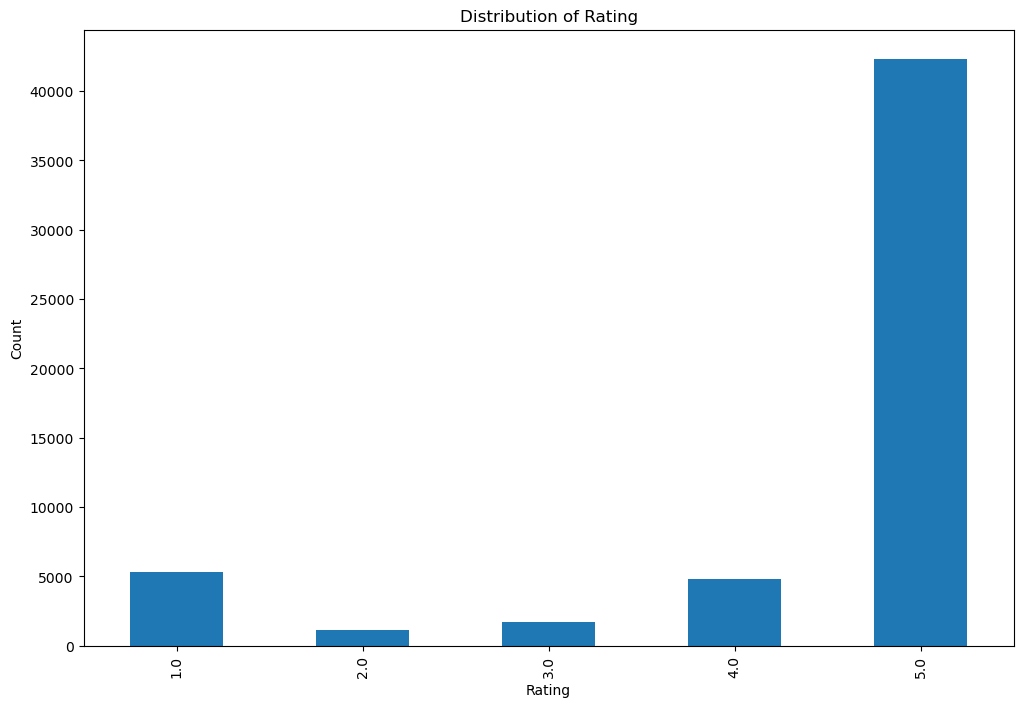

In [96]:
# Plot distribution of rating
plt.figure(figsize=(7,3))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 10 Highest-Reviewed Processors')

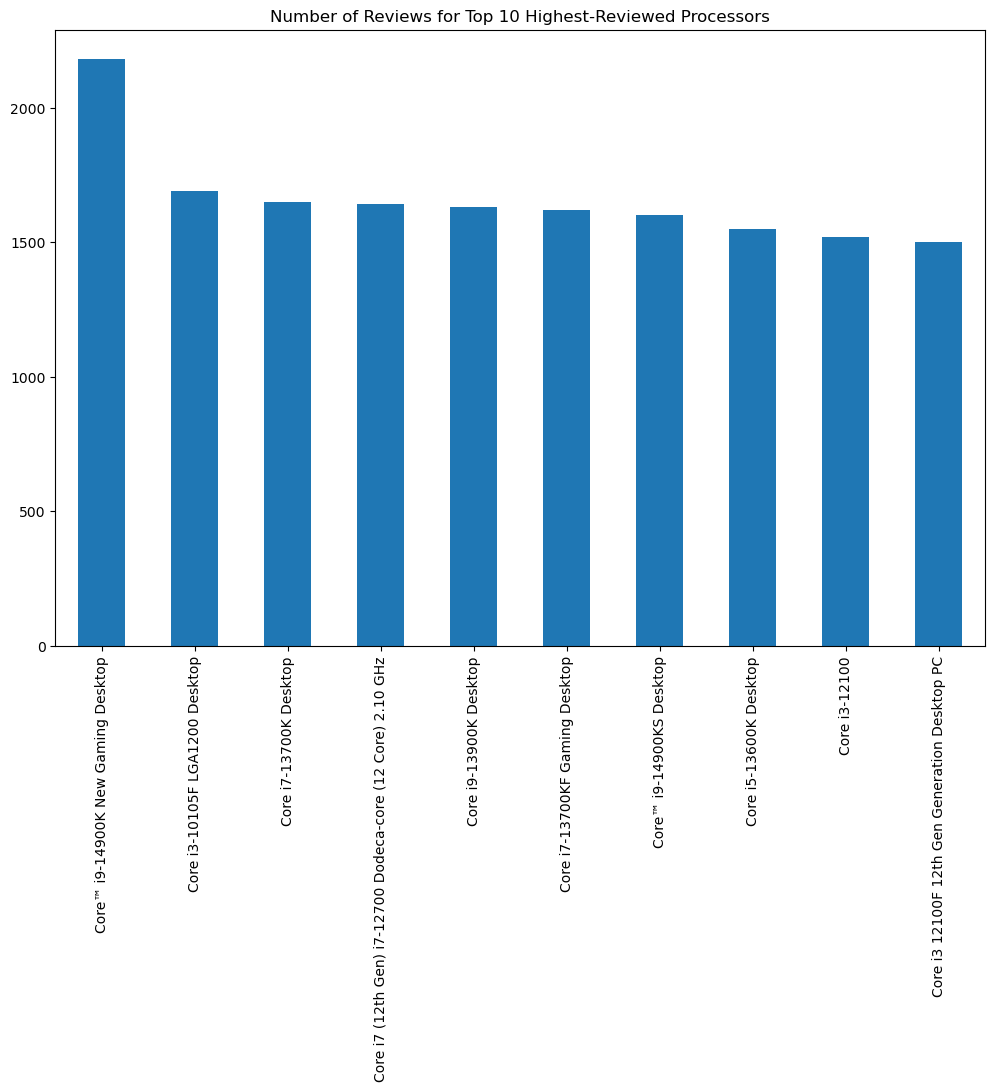

In [97]:
# Plot number of reviews for top 10
brands = df["Model"].value_counts()
# brands.count()
plt.figure(figsize=(7,3))
brands[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Highest-Reviewed Processors")

Text(0, 0.5, 'Count')

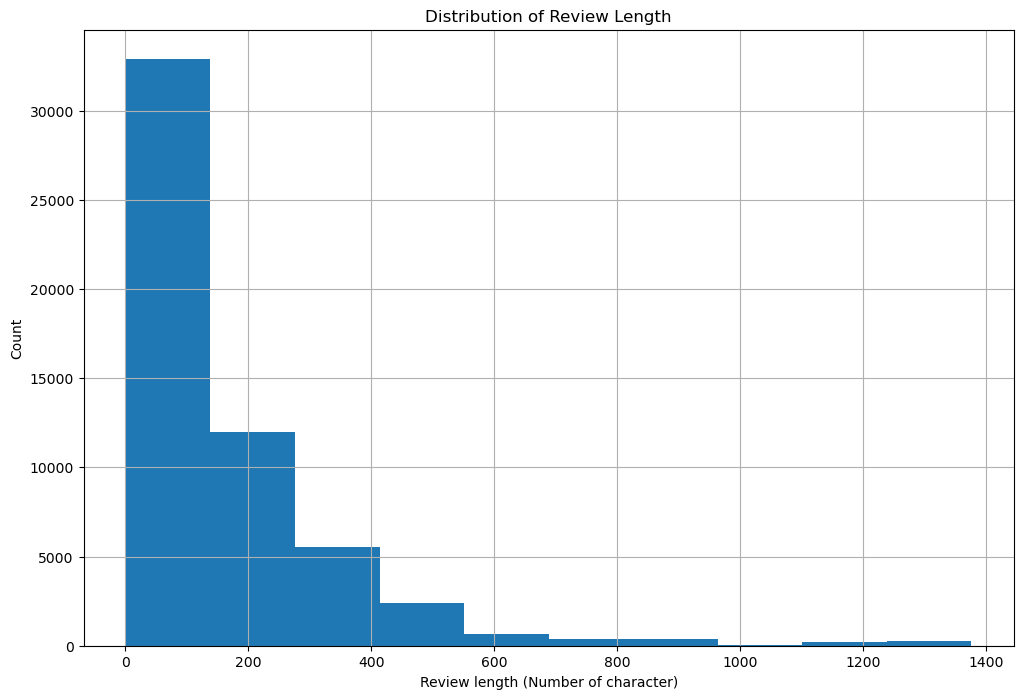

In [98]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(7,3))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

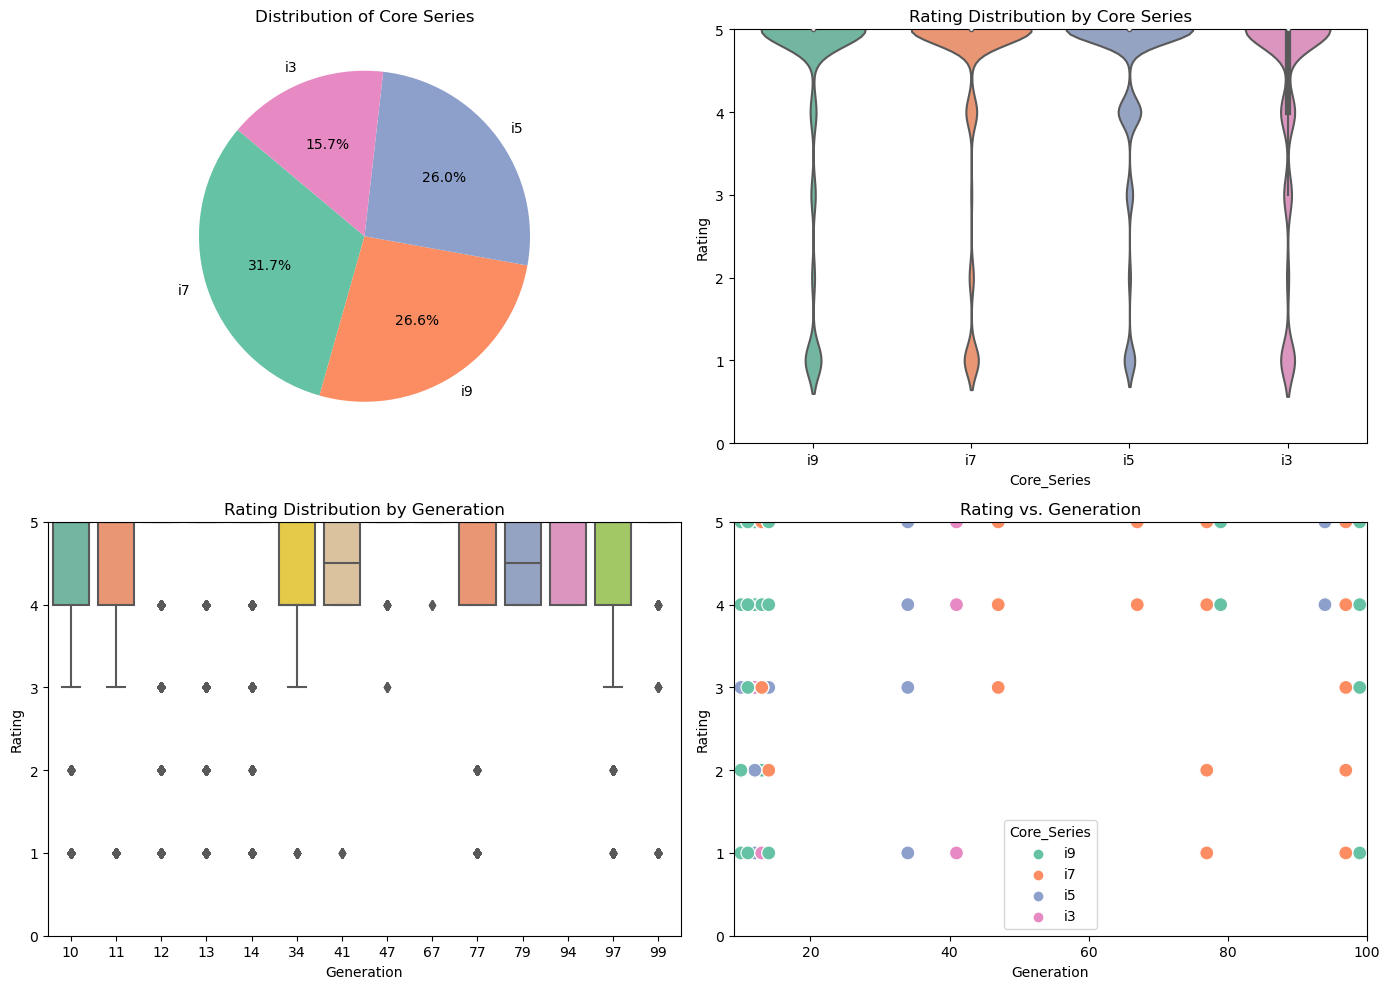

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Pie chart of Core Series distribution
core_series_counts = df['Core_Series'].value_counts()
axs[0, 0].pie(core_series_counts, labels=core_series_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
axs[0, 0].set_title('Distribution of Core Series')

# Plot 2: Violin plot of Ratings by Core Series
sns.violinplot(data=df, x='Core_Series', y='Rating', palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Rating Distribution by Core Series')
axs[0, 1].set_ylim(0, 5)

# Plot 3: Box plot of Ratings by Generation
sns.boxplot(data=df, x='Generation', y='Rating', palette='Set2', ax=axs[1, 0])
axs[1, 0].set_title('Rating Distribution by Generation')
axs[1, 0].set_ylim(0, 5)

# Plot 4: Scatter plot of Rating vs. Generation
sns.scatterplot(data=df, x='Generation', y='Rating', hue='Core_Series', palette='Set2', s=100, ax=axs[1, 1])
axs[1, 1].set_title('Rating vs. Generation')
axs[1, 1].set_ylim(0, 5)
axs[1, 1].set_xlim(df['Generation'].min() - 1, df['Generation'].max() + 1)

plt.tight_layout()
plt.show()

---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [100]:
df = df.sample(frac=1, random_state=71) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

#Remove any 'neutral' ratings equal to 3
#df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head(40)

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
42044,Intel,i3,10,Core i3-10100,1.0,21 November 2020,India,Processor box was already open. But thank God ...,0
11401,Intel,i7,13,Core i7-13700K Desktop,5.0,24 July 2023,Canada,This processor performs well and is a solid pe...,1
43910,Intel,i7,13,Core i7-13700KF Gaming Desktop,4.0,17 June 2023,France,Pas de problème pour moi....,1
3247,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2 January 2024,the United States,I got this CPU because I've been a long term I...,1
8671,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,24 April 2024,Germany,The seller posted the item but there was a del...,1
52039,Intel,i3,10,Core i3-10100F 10th Generation LGA1200 Desktop,5.0,3 October 2023,India,Kerala Kozhikode,1
2322,Intel,i7,13,Core i7-13700K Desktop,5.0,24 April 2024,Spain,Muy buena marca,1
51799,Intel,i7,47,Core i7-4790K Unlocked 4.0 GHz Quad Core LGA11...,5.0,10 September 2016,India,Processor is so fast.Best for gamming & Video ...,1
38256,Intel,i3,12,Core i3 12100F 12th Gen Generation Desktop PC,5.0,27 January 2024,Brazil,"Muito bom, super recomendo",1
7197,Intel,i9,13,Core™ i9-13900F,1.0,6 March 2024,Italy,Davvero deluso!,0


In [101]:
def is_english(text):
  """Checks if the text is in English using langdetect"""
  try:
    return langdetect.detect(text) == 'en'
  except langdetect.LangDetectException:  # Handle potential errors
    return False

# Drop rows with missing reviews or non-English reviews
df = df[df['Reviews'].notnull() & df['Reviews'].apply(is_english)]

df.head(5)

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
42044,Intel,i3,10,Core i3-10100,1.0,21 November 2020,India,Processor box was already open. But thank God ...,0
11401,Intel,i7,13,Core i7-13700K Desktop,5.0,24 July 2023,Canada,This processor performs well and is a solid pe...,1
3247,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2 January 2024,the United States,I got this CPU because I've been a long term I...,1
8671,Intel,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,24 April 2024,Germany,The seller posted the item but there was a del...,1
51799,Intel,i7,47,Core i7-4790K Unlocked 4.0 GHz Quad Core LGA11...,5.0,10 September 2016,India,Processor is so fast.Best for gamming & Video ...,1


In [102]:
df.shape

(33042, 9)

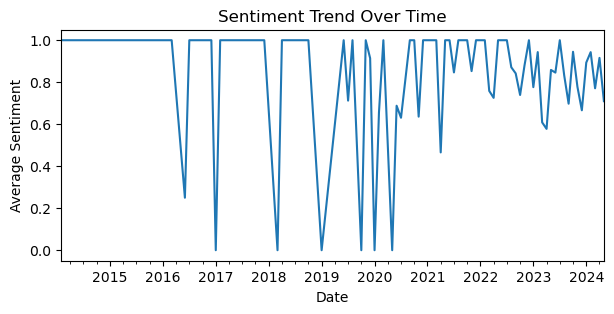

In [103]:
df['Date'] = pd.to_datetime(df['Date'], format='%d %B %Y')

# Plot sentiment trends over time
plt.figure(figsize=(7, 3))
df.groupby(df['Date'].dt.to_period('M'))['Sentiment'].mean().plot(kind='line')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()

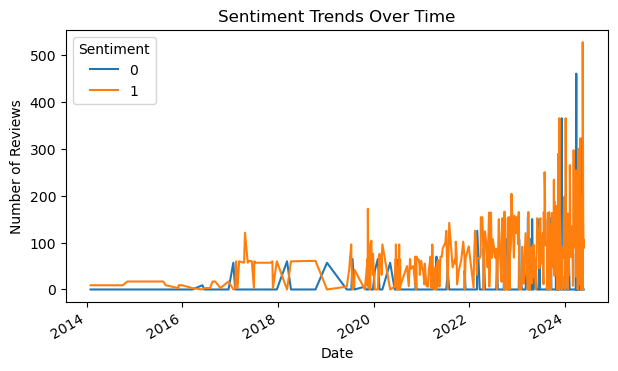

In [104]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group data by date and sentiment, count occurrences, and unstack the result
sentiment_trend = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trends over time
sentiment_trend.plot(kind='line', figsize=(7, 4))

# Add title and labels
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

# Show plot
plt.show()


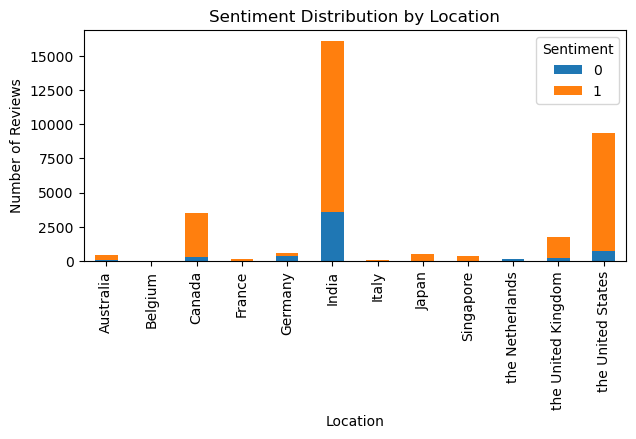

In [105]:
location_sentiment_count = df.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment counts for each location
location_sentiment_count.plot(kind='bar', stacked=True, figsize=(7, 3))

# Add title and labels
plt.title('Sentiment Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Number of Reviews')

# Show legend
plt.legend(title='Sentiment')

# Show plot
plt.show()

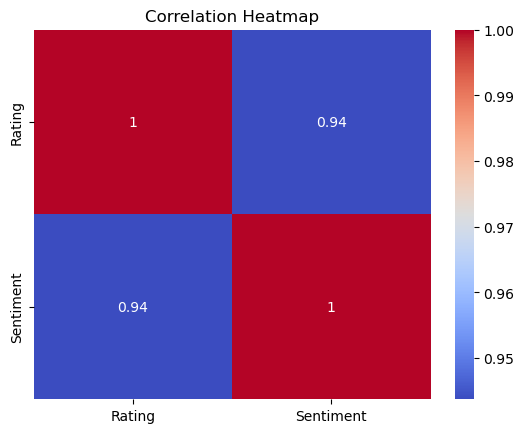

In [106]:
import seaborn as sns

# Select columns for the heatmap
columns = ['Rating', 'Sentiment']

# Compute the correlation matrix
correlation_matrix = df[columns].corr()

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [109]:
# Now we remove Brand column as it is redundant
df.drop(columns=['Brand'], inplace=True)
df

,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
42044,i3,10,Core i3-10100,1.0,2020-11-21,India,Processor box was already open. But thank God ...,0
11401,i7,13,Core i7-13700K Desktop,5.0,2023-07-24,Canada,This processor performs well and is a solid pe...,1
3247,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2024-01-02,the United States,I got this CPU because I've been a long term I...,1
8671,i5,14,CoreTM i5-14600K LGA 1700 Socket New Gaming De...,5.0,2024-04-24,Germany,The seller posted the item but there was a del...,1
51799,i7,47,Core i7-4790K Unlocked 4.0 GHz Quad Core LGA11...,5.0,2016-09-10,India,Processor is so fast.Best for gamming & Video ...,1
...,...,...,...,...,...,...,...,...
38945,i3,10,Core i3-10105F LGA1200 Desktop,5.0,2024-04-27,the United Kingdom,Really good and can basically run any game I t...,1
50086,i3,10,Core i3-10100F 10th Generation LGA1200 Desktop,4.0,2021-07-10,India,If you are buying this processor you need to h...,1
47866,i7,77,Core™ i7-7700,5.0,2017-11-07,India,First of all thanks to the B Online Store for ...,1
35553,i9,14,Core™ i9-14900K New Gaming Desktop,1.0,2024-03-28,India,I don't liked the price of it .,0


### Train Test Split 

In [112]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df["Reviews"], df["Sentiment"],
                                                   test_size=0.35, random_state=50)

print('Loaded %d training examples and %d validation examples.\n' % (X_train.shape[0], X_test.shape[0]))

# Print a sample review from the training set
print('Sample review in the training set:\n', X_train.iloc[0])  # Use iloc to access by positional index

# Example of iterating through first few reviews in training set
print('\nFirst few reviews in the training set:')
for i in range(5):
    print(f'Review {i+1}: {X_train.iloc[i]}')


Loaded 21477 training examples and 11565 validation examples.

Sample review in the training set:
 Its working fine but it seems overheating in 100% usage. Temperature goes upto 93°c during stress test(Stock cpu cooler).

First few reviews in the training set:
Review 1: Its working fine but it seems overheating in 100% usage. Temperature goes upto 93°c during stress test(Stock cpu cooler).
Review 2: I love the chip but I noticed something strange. The stock cooler had hardened thermal paste on it. It looks like this was used and resold at a new price. I have never seen a stock cooler come with thermal paste on it and especially not hardened crusty thermal paste. I had to clean it off with rubbing alcohol. Other than that, the chip is a good one and a nice balance between great performance and efficiency with its 65 TDP. I just can't believe that the stock cooler had thermal paste on it and it appears to be used. I have never had that happen before.
Review 3: It's not Amazon's issue but

---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [113]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [114]:
from bs4 import BeautifulSoup
import numpy as np

# Assuming X_train and X_test are lists of text data
# Define a function to clean text data

# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n')
for i in range(5):
    print(X_train_cleaned[i])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

C:\Users\Aviral Srivastava\AppData\Local\Temp\ipykernel_24032\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Show a cleaned review in the training set : 

its working fine but it seems overheating in usage temperature goes upto c during stress test stock cpu cooler
i love the chip but i noticed something strange the stock cooler had hardened thermal paste on it it looks like this was used and resold at a new price i have never seen a stock cooler come with thermal paste on it and especially not hardened crusty thermal paste i had to clean it off with rubbing alcohol other than that the chip is a good one and a nice balance between great performance and efficiency with its tdp i just can t believe that the stock cooler had thermal paste on it and it appears to be used i have never had that happen before
it s not amazon s issue but the processor i bought is faulty i m experiencing crashes while playing games it s so annoying and so time consuming i had so many stressful moments because of this
it the one of the processor which all in one
most powerful cpu at this price bracket no doubt amazing 

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" % len(countVect.get_feature_names_out())) #6378 
print("Show some feature names : \n", countVect.get_feature_names_out()[1::1000])

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


Number of features : 2270 

Show some feature names : 
 ['ability' 'kauft' 'throttles']


MultinomialNB()

In [116]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [117]:
# Evaluate the model on validaton set
X_test_features = countVect.transform(X_test_cleaned) 
predictions = mnb.predict(X_test_features)
modelEvaluation(predictions)


Accuracy on validation set: 0.9817

AUC score : 0.9623

Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      1944
           1       0.99      0.99      0.99      9621

    accuracy                           0.98     11565
   macro avg       0.97      0.96      0.97     11565
weighted avg       0.98      0.98      0.98     11565


Confusion Matrix : 
 [[1814  130]
 [  82 9539]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [118]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[1::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 2547 

Show some feature names : 
 ['0ghz' 'fooled' 'seeing']


LogisticRegression()

In [119]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['broken' 'ryzen' 'information' 'worst' 'properly' 'overheating' 'ok'
 'don' 'liked' 'received']

Top 10 features with largest coefficients : 
['great' 'for' 'good' 'which' 'need' 'best' 'fast' 'beast' 'i5' 'an']


In [120]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9977

AUC score : 0.9941

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1944
           1       1.00      1.00      1.00      9621

    accuracy                           1.00     11565
   macro avg       1.00      0.99      1.00     11565
weighted avg       1.00      1.00      1.00     11565


Confusion Matrix : 
 [[1922   22]
 [   5 9616]]


### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [121]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}

Accuracy on validation set: 1.0000

AUC score : 1.0000

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1944
           1       1.00      1.00      1.00      9621

    accuracy                           1.00     11565
   macro avg       1.00      1.00      1.00     11565
weighted avg       1.00      1.00      1.00     11565


Confusion Matrix : 
 [[1944    0]
 [   0 9621]]


---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [122]:
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer
import nltk
nltk.download('punkt')

# Define the tokenizer
tokenizer = PunktSentenceTokenizer()

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(word_tokenize(cleanText(raw_sentence, remove_stopwords)))
    return sentences

# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentences in the training set\n' % len(sentences))
print("Some parsed sentences from the training set:")
for i in range(5):  # Adjust the range as needed
    print(f"Sentence {i+1}: {sentences[i]}")



[nltk_data] Downloading package punkt to C:\Users\Aviral
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


21477 parsed sentences in the training set

Some parsed sentences from the training set:
Sentence 1: ['its', 'working', 'fine', 'but', 'it', 'seems', 'overheating', 'in', 'usage', 'temperature', 'goes', 'upto', 'c', 'during', 'stress', 'test', 'stock', 'cpu', 'cooler']
Sentence 2: ['i', 'love', 'the', 'chip', 'but', 'i', 'noticed', 'something', 'strange', 'the', 'stock', 'cooler', 'had', 'hardened', 'thermal', 'paste', 'on', 'it', 'it', 'looks', 'like', 'this', 'was', 'used', 'and', 'resold', 'at', 'a', 'new', 'price', 'i', 'have', 'never', 'seen', 'a', 'stock', 'cooler', 'come', 'with', 'thermal', 'paste', 'on', 'it', 'and', 'especially', 'not', 'hardened', 'crusty', 'thermal', 'paste', 'i', 'had', 'to', 'clean', 'it', 'off', 'with', 'rubbing', 'alcohol', 'other', 'than', 'that', 'the', 'chip', 'is', 'a', 'good', 'one', 'and', 'a', 'nice', 'balance', 'between', 'great', 'performance', 'and', 'efficiency', 'with', 'its', 'tdp', 'i', 'just', 'can', 't', 'believe', 'that', 'the', 'stock'

### Creating Volcabulary List using Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word vector representations by sepcifiying the embedding dimension (= length of feature vector).

In [135]:
import logging
import re
from gensim.models import Word2Vec

# Enable logging for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # Embedding dimension
min_word_count = 10  # Minimum word count
num_workers = 4  # Number of threads to run in parallel
context = 10  # Context window size
downsampling = 1e-3  # Downsample setting for frequent words

print("Training Word2Vec model ...\n")

# Assume `sentences` is your list of tokenized sentences
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count=min_word_count,
               window=context, sample=downsampling)

# To make the model memory-efficient
w2v.init_sims(replace=True)

# Save the model
w2v.save("w2v_300features_10minwordcounts_10context")

# Remove punctuation and other symbols from the vocabulary list
cleaned_vocabulary = [word for word in w2v.wv.index_to_key if re.match(r'^\w+$', word)]

print("Number of words in the cleaned vocabulary list: %d \n" % len(cleaned_vocabulary))
print("Show words in the cleaned vocabulary list: \n", cleaned_vocabulary)


C:\Users\Aviral Srivastava\AppData\Roaming\Python\Python311\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(
2024-06-22 13:23:46,118 : INFO : collecting all words and their counts
2024-06-22 13:23:46,120 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-22 13:23:46,225 : INFO : PROGRESS: at sentence #10000, processed 356333 words, keeping 2282 word types
2024-06-22 13:23:46,287 : INFO : PROGRESS: at sentence #20000, processed 715291 words, keeping 2291 word types
2024-06-22 13:23:46,306 : INFO : collected 2291 word types from a corpus of 765686 raw words and 21477 sentences


Training Word2Vec model ...



2024-06-22 13:23:46,306 : INFO : Loading a fresh vocabulary
2024-06-22 13:23:46,312 : INFO : effective_min_count=10 retains 2125 unique words (92% of original 2291, drops 166)
2024-06-22 13:23:46,312 : INFO : effective_min_count=10 leaves 764815 word corpus (99% of original 765686, drops 871)
2024-06-22 13:23:46,321 : INFO : deleting the raw counts dictionary of 2291 items
2024-06-22 13:23:46,323 : INFO : sample=0.001 downsamples 61 most-common words
2024-06-22 13:23:46,323 : INFO : downsampling leaves estimated 560009 word corpus (73.2% of prior 764815)
2024-06-22 13:23:46,330 : INFO : estimated required memory for 2125 words and 300 dimensions: 6162500 bytes
2024-06-22 13:23:46,330 : INFO : resetting layer weights
2024-06-22 13:23:46,611 : INFO : training model with 4 workers on 2125 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2024-06-22 13:23:56,529 : INFO : EPOCH 1 - PROGRESS: at 1.28% examples, 733 words/s, in_qsize 8, out_qsize 0
2024-06-22 13:2

### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [128]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model.wv.word_vec(word))
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [130]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" % trainVector.shape)

# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" % testVector.shape)

C:\Users\Aviral Srivastava\AppData\Local\Temp\ipykernel_24032\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


NameError: name 'w2v' is not defined

### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=7)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9740

AUC score : 0.9151

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.83      0.91      2086
           1       0.97      1.00      0.98     11516

    accuracy                           0.97     13602
   macro avg       0.99      0.92      0.95     13602
weighted avg       0.97      0.97      0.97     13602


Confusion Matrix : 
 [[ 1732   354]
 [    0 11516]]


---
<a id="part5"></a>
## Part 5. LSTM



Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

C:\Users\Aviral Srivastava\AppData\Roaming\Python\Python311\site-packages\keras\src\legacy\preprocessing\text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train shape: (25260, 100)
X_test shape: (13602, 100)
y_train shape: (25260, 2)
y_test shape: (13602, 2)


In [ ]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128, activity_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3)))
model1.add(Dropout(0.2))
model1.add(LSTM(128)) 
model1.add(Dropout(0.3))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.8825 - loss: 2.9866
Epoch 2/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.9967 - loss: 1.8377
Epoch 3/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.9990 - loss: 1.8054
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9992 - loss: 2.0479
Test loss : 2.0461
Test accuracy : 0.9988


In [ ]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[4].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 2)


### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

2024-06-17 22:12:56,505 : INFO : loading Word2Vec object from w2v_300features_10minwordcounts_10context
2024-06-17 22:12:56,515 : INFO : loading wv recursively from w2v_300features_10minwordcounts_10context.wv.* with mmap=None
2024-06-17 22:12:56,515 : INFO : setting ignored attribute cum_table to None
2024-06-17 22:12:56,531 : INFO : Word2Vec lifecycle event {'fname': 'w2v_300features_10minwordcounts_10context', 'datetime': '2024-06-17T22:12:56.531656', 'gensim': '4.3.0', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}


Shape of embedding matrix :  (2267, 300)


In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train_cleaned shape:', X_train_seq.shape) #(27799, 100)
print('X_test_cleaned shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

C:\Users\Aviral Srivastava\AppData\Roaming\Python\Python311\site-packages\keras\src\legacy\preprocessing\text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train_cleaned shape: (25260, 100)
X_test_cleaned shape: (13602, 100)
y_train shape: (25260, 2)
y_test shape: (13602, 2)


In [ ]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix],
                           activity_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-2))


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Dropout(0.3))
model2.add(LSTM(128)) 
model2.add(Dropout(0.3))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       680,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 680,100 (2.59 MB)

 Trainable params: 680,100 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.8886 - loss: 10.4007
Epoch 2/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.9953 - loss: 4.8594
Epoch 3/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.9972 - loss: 5.4853
426/426 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9988 - loss: 4.6108
Test loss : 4.6027
Test accuracy : 0.9982


In [ ]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[4].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (2267, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [ ]:
print(df.columns)
df.head()

Index(['index', 'Brand', 'Model', 'Rating', 'Date', 'Location', 'Reviews',
       'Sentiment'],
      dtype='object')


,index,Brand,Model,Rating,Date,Location,Reviews,Sentiment
0,65060,Intel,Core i3-13100 Desktop,5.0,2023-11-11,the United Kingdom,Great performance,1
1,42786,Intel,Core i3-10105F LGA1200 Desktop,5.0,2024-04-27,the United Kingdom,Really good and can basically run any game I t...,1
2,5122,Intel,Core i5-14400F Desktop,5.0,2024-04-06,the United States,if you have a 13th gen dont upgrade.,1
3,27909,Intel,Core I5 12400F 12 Gen Generation Desktop Pc,4.0,2024-02-18,India,"This will not work without graphic card, So be...",1
4,20300,Intel,Core i5-10th Gen,5.0,2021-04-11,Canada,I was tired of my old Q66 lagging in the lates...,1


In [ ]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download NLTK stopwords
nltk.download('stopwords')

def create_word_cloud(Sentiment):
  try:
    df_sample = df.sample(frac=1)  # Sample from the entire DataFrame

    # Preprocess data (outside the loop)
    stop_words = set(stopwords.words('english'))
    positive_tokens = []
    negative_tokens = []
    for review in df_sample['Reviews']:
      tokens = nltk.word_tokenize(review.lower())
      filtered_tokens = [word for word in tokens if word not in stop_words]
      if Sentiment == 1:
        positive_tokens.extend(filtered_tokens)
      else:
        negative_tokens.extend(filtered_tokens)

    # Generate word cloud based on sentiment
    if Sentiment == 1:
      text = ' '.join(positive_tokens)
    else:
      text = ' '.join(negative_tokens)

    wordcloud = WordCloud(max_font_size=30, width=200, height=100).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
  except Exception as e:
    print(e)

[nltk_data] Downloading package stopwords to C:\Users\Aviral
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


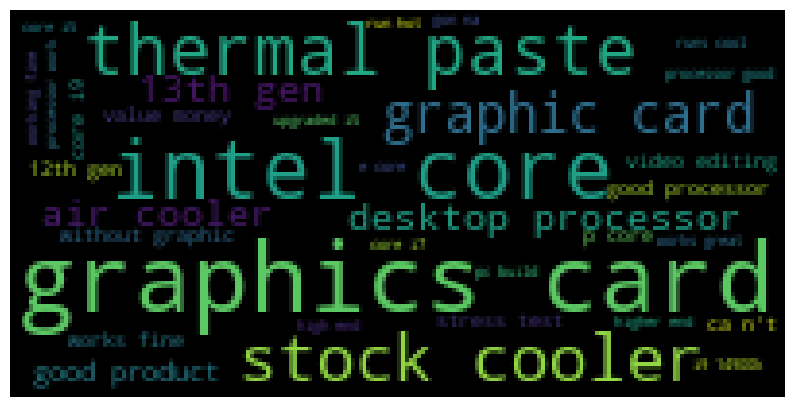

In [ ]:
create_word_cloud(Sentiment=1)


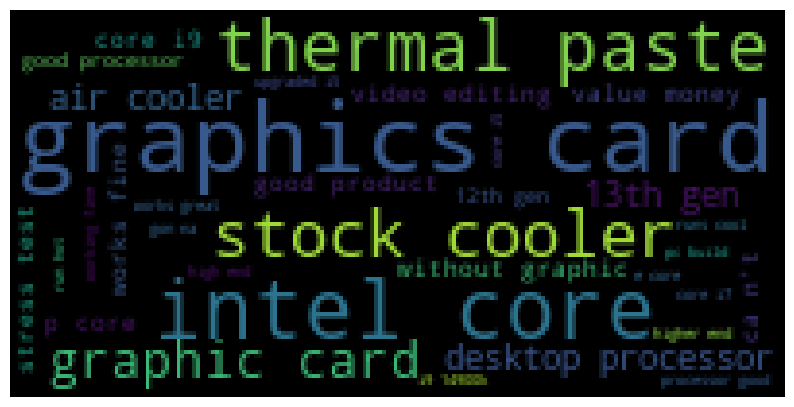

In [ ]:
create_word_cloud(Sentiment=0)

426/426 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


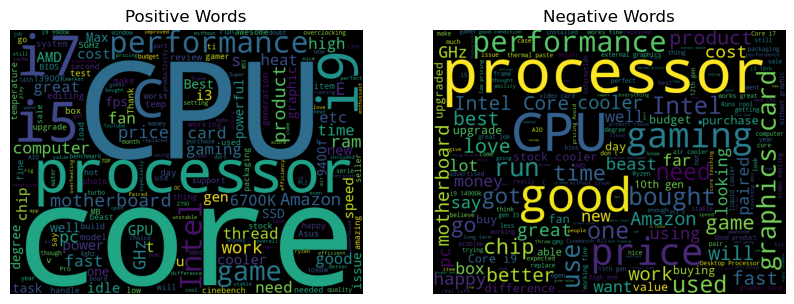

In [ ]:
predictions = model2.predict(X_test_seq)  # Get probabilities for each sentiment class
predictions = np.argmax(predictions, axis=-1) 
# Initialize empty lists for positive and negative words
positive_words = []
negative_words = []

# Loop through reviews, predictions, and pre-trained embeddings (assuming you have them)
for review, sentiment, embedding in zip(df["Reviews"], predictions, X_test_seq):
  words = review.split()  # Split review into words
  embedding_list = embedding.tolist()  # Assuming embedding is a numpy array

  # Filter words based on predicted sentiment and embedding existence
  for word, word_embedding in zip(words, embedding_list):
    if word_embedding is not None:  # Check if embedding exists (optional)
      if sentiment == 1:  # Positive sentiment
        if word not in positive_words:  # Add unique words to list
          positive_words.append(word)
      else:  # Negative sentiment
        negative_words.append(word)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=600).generate(" ".join(positive_words))
negative_wordcloud = WordCloud(width=800, height=600).generate(" ".join(negative_words))

# Display or save word clouds
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(positive_wordcloud)
plt.title('Positive Words')
plt.axis("off")

plt.subplot(122)
plt.imshow(negative_wordcloud)
plt.title('Negative Words')
plt.axis("off")

plt.show()

[nltk_data] Downloading package stopwords to C:\Users\Aviral
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aviral
[nltk_data]     Srivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


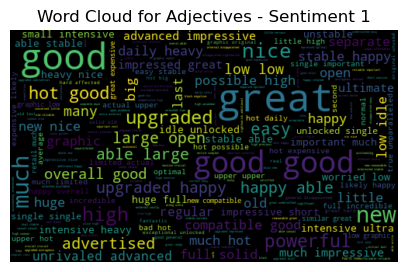

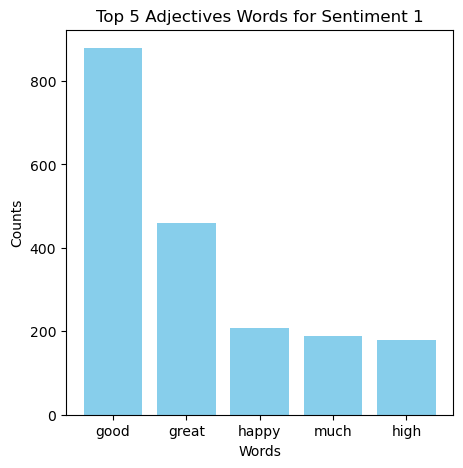

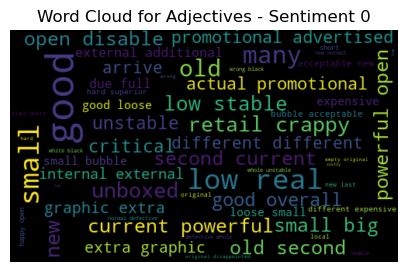

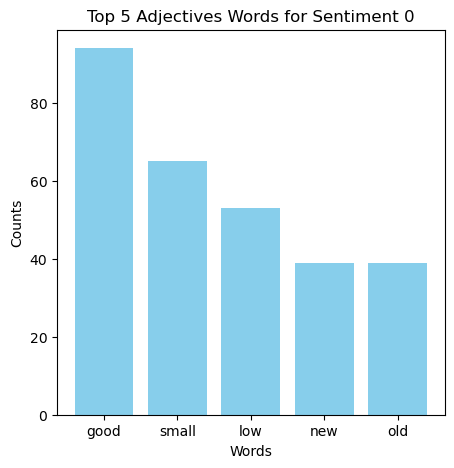

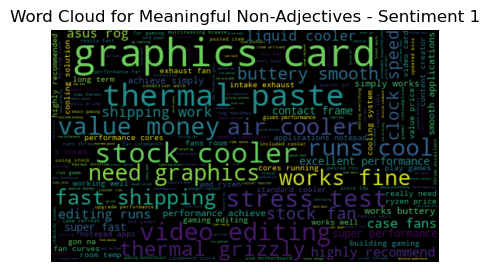

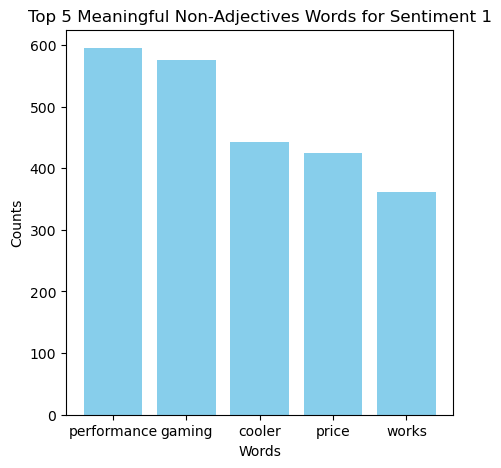

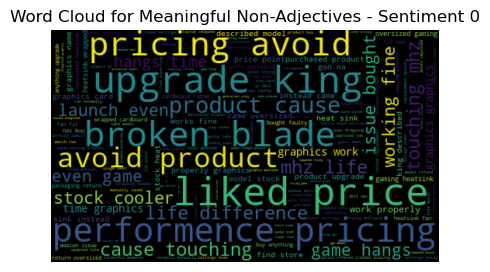

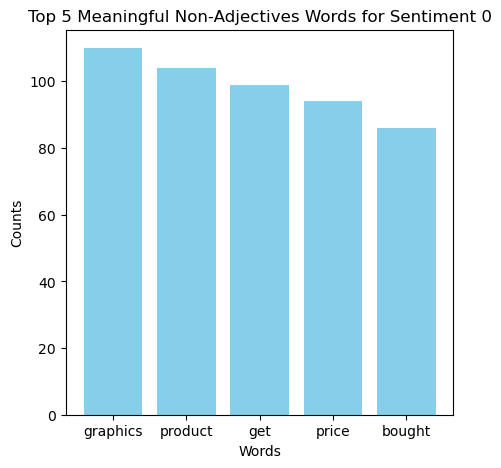

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK stopwords and part-of-speech tagger
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def is_adjective(word):
    """Check if a word is an adjective."""
    return pos_tag([word])[0][1] == 'JJ'

def is_meaningful(word):
    """Check if a word is a meaningful non-adjective."""
    pos_tagged = pos_tag([word])[0][1]
    # Include only nouns, verbs, and adverbs
    return pos_tagged.startswith('N') or pos_tagged.startswith('V') or pos_tagged == 'RB'

# Extend stopwords with common non-characteristic words
additional_stopwords = {'cpu', 'processor', 'monitor', 'pc', 'computer', 'intel', 'core', 'generation', 'desktop', 'gen', 'i5', 'i7', 'i9', 'pentium'}
stop_words = set(stopwords.words('english')).union(additional_stopwords)

def create_word_cloud_with_top_words(sentiment, adjectives_only=True):
    df_sample = df[df['Sentiment'] == sentiment]
    df_sample = df_sample.sample(frac=0.1, random_state=0)
    
    word_cloud_collection = ''
    
    for val in df_sample['Reviews'].str.lower():
        tokens = nltk.word_tokenize(val)
        if adjectives_only:
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words and is_adjective(word)]
        else:
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words and is_meaningful(word)]
        word_cloud_collection += ' '.join(tokens) + ' '
    
    wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    sentiment_type = 'Adjectives' if adjectives_only else 'Meaningful Non-Adjectives'
    plt.title(f'Word Cloud for {sentiment_type} - Sentiment {sentiment}')
    plt.show()
    
    # Plot top 5 words
    word_counts = Counter(word_cloud_collection.split())
    top_5_words = word_counts.most_common(5)
    
    words, counts = zip(*top_5_words)
    plt.figure(figsize=(5, 5))
    plt.bar(words, counts, color='skyblue')
    plt.title(f'Top 5 {sentiment_type} Words for Sentiment {sentiment}')
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

# Create word clouds and top words for positive (1) and negative (0) sentiments
# For Adjectives
create_word_cloud_with_top_words(1, adjectives_only=True)
create_word_cloud_with_top_words(0, adjectives_only=True)

# For Meaningful Non-Adjectives
create_word_cloud_with_top_words(1, adjectives_only=False)
create_word_cloud_with_top_words(0, adjectives_only=False)


In [ ]:
# Sentences to be analyzed
sentences = ["This model was fantastic!", "I hated this product.", "The product is just okay today."]

# Tokenize and pad the input sentences
sequences = tokenizer.texts_to_sequences(sentences)
preprocessed_sentences = sequence.pad_sequences(sequences, maxlen=maxlen)

# Get predictions
predictions = model2.predict(preprocessed_sentences)

# Show predictions
for sentence, prediction in zip(sentences, predictions):
    sentiment = 'Positive' if prediction[0] > 0.5 else 'Negative'
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 20)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Sentence: This model was fantastic!
Predicted Sentiment: Negative
--------------------
Sentence: I hated this product.
Predicted Sentiment: Negative
--------------------
Sentence: The product is just okay today.
Predicted Sentiment: Negative
--------------------


In [ ]:
# Sentences to be analyzed
sentences = ["This model was fantastic!", "I hated this product.", "The product is just okay today. Not satisfied"]

# Tokenize and pad the input sentences
sequences = tokenizer.texts_to_sequences(sentences)
preprocessed_sentences = sequence.pad_sequences(sequences, maxlen=maxlen)

# Get predictions
predictions = model2.predict(preprocessed_sentences)

# Show predictions
for sentence, prediction in zip(sentences, predictions):
    sentiment = 'Positive' if prediction[0] > 0.5 else 'Negative'
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 20)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sentence: This model was fantastic!
Predicted Sentiment: Negative
--------------------
Sentence: I hated this product.
Predicted Sentiment: Negative
--------------------
Sentence: The product is just okay today. Not satisfied
Predicted Sentiment: Negative
--------------------


In [ ]:
#Summarizing the reviews

In [ ]:
from transformers import pipeline

c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
summariser=pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


c:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aviral Srivastava\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Using BERT: BERT (Bidirectional Encoder Representations from Transformers) is a powerful language model that can be used for text summarization. BERT-based models have achieved state-of-the-art results in various natural language processing tasks, including text summarization.

In [ ]:
from transformers import pipeline

# Initialize the BERT summarization pipeline with the specific model
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Get positive texts from the 'text' column in your dataset
positive_texts = X_train_cleaned

# Combine all positive texts into one string
combined_text = " ".join(positive_texts)

# Split the combined text into chunks of maximum length 1024
texts = []
chunk = ""
for sentence in combined_text.split():
    if len(chunk) + len(sentence) > 1024:
        texts.append(chunk)
        chunk = ""
    chunk += sentence + " "
if chunk:
    texts.append(chunk)

# Generate summaries for each chunk of text
for i, text in enumerate(texts):
    if i >= 10:
        break
    print("\nSummary:")
    summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
    print(summary[0]['summary_text'])




Summary:
 bios updated latest late march cpu would run normally manually tuned intel settings even dropping speeds well low stock trying multiple voltage power settings . It takes three weeks refund replacement option offered got sale k really enjoyed processor heatsink fan provided .

Summary:
 people thought crazy performance matter good product excellent processor great gaming editing efficient . specially times energy crisis decided write review many questions received desktop computer components purchased amazon .

Summary:
 Video cards xxx series selling triple list price want spend k video card gtx frame rates gone significantly valerant games play went frames frames frames happy th gen mast hai bhai le lo working good use gaming pc said k absolute amazing .

Summary:
 Best gaming processor far running smoothly running smoothly fast shipping works advertised cores thread ghz best gaming processor . Best use motherboard ddr  ddr pci e    Best use of motherboard dDr pci e .

Summ